# Assignment 2

### Python Version: 3.6
* conda create --name py3.6 python=3.6
* source activate py3.6
* python -V

### Java Version:  8
* brew cask install adoptopenjdk/openjdk/adoptopenjdk8
* open ~/.bash_profile
* export JAVA_HOME=$(/usr/libexec/java_home -v 1.8)
* java -version

## Step 01: Import Spark Session and initialize Spark

In [1]:
import pyspark
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.master("local").appName("Weather Forecast").getOrCreate()

## Step 02: Load the dataset and print the schema and total number of entries

In [3]:
# df = spark.read.csv('weatherAUS.csv', header=True)

In [4]:
# df.describe().collect()

In [5]:
df = spark.read.csv('weatherAUS.csv', header=True)

In [6]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



In [7]:
df.count()

142193

## Step 03: Delete columns from the dataset

In [8]:
df = df.drop('Date', 'Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm')
df.show(0)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
only showing top 0 rows



## Step 04: Print the number of missing data in each column.

In [9]:
from pyspark.sql.functions import col, sum

df.select(*(sum(col(c).isin('NA').cast("int")).alias(c) for c in df.columns)).show()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|    637|    322|    1406|       9330|         9270|     10013|      3778|        1348|        2630|       1774|       3610|      14014|      13981|     1406|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



## Step 05: Fill the missing data with average value and maximum occurrence value.

In [10]:
from pyspark.sql.functions import avg

df.select(avg('MinTemp'),
          avg('MaxTemp'),
          avg('Rainfall'),
          avg('WindGustSpeed'),
          avg('WindSpeed9am'),
          avg('WindSpeed3pm'),
          avg('Humidity9am'),
          avg('Humidity3pm'),
          avg('Pressure9am'),
          avg('Pressure3pm')).show()

avg_list = df.select(avg('MinTemp'), 
                     avg('MaxTemp'), 
                     avg('Rainfall'), 
                     avg('WindGustSpeed'), 
                     avg('WindSpeed9am'), 
                     avg('WindSpeed3pm'), 
                     avg('Humidity9am'), 
                     avg('Humidity3pm'), 
                     avg('Pressure9am'), 
                     avg('Pressure3pm')).collect()

+------------------+------------------+------------------+------------------+-----------------+-----------------+----------------+------------------+------------------+-----------------+
|      avg(MinTemp)|      avg(MaxTemp)|     avg(Rainfall)|avg(WindGustSpeed)|avg(WindSpeed9am)|avg(WindSpeed3pm)|avg(Humidity9am)|  avg(Humidity3pm)|  avg(Pressure9am)| avg(Pressure3pm)|
+------------------+------------------+------------------+------------------+-----------------+-----------------+----------------+------------------+------------------+-----------------+
|12.186399728729098|23.226784191272444|2.3499740743111954| 39.98429165757619|  14.001988000994|18.63757586179718|68.8438103105705|51.482606091656265|1017.6537584159781|1015.258203537907|
+------------------+------------------+------------------+------------------+-----------------+-----------------+----------------+------------------+------------------+-----------------+



In [11]:
from pyspark.sql.functions import max

df.select(max('WindGustDir'),
          max('WindDir9am'),
          max('WindDir3pm'),
          max('RainToday'),
          max('RainTomorrow'),
         ).show()

max_list = df.select(max('WindGustDir'),
                     max('WindDir9am'),
                     max('WindDir3pm'),
                     max('RainToday'),
                     max('RainTomorrow'),
                    ).collect()

+----------------+---------------+---------------+--------------+-----------------+
|max(WindGustDir)|max(WindDir9am)|max(WindDir3pm)|max(RainToday)|max(RainTomorrow)|
+----------------+---------------+---------------+--------------+-----------------+
|             WSW|            WSW|            WSW|           Yes|              Yes|
+----------------+---------------+---------------+--------------+-----------------+



In [12]:
from pyspark.sql.functions import when

df = df\
.withColumn('MinTemp', when(df.MinTemp=='NA', avg_list[0][0]).otherwise(df.MinTemp))\
.withColumn('MaxTemp', when(df.MaxTemp=='NA', avg_list[0][1]).otherwise(df.MaxTemp))\
.withColumn('Rainfall', when(df.Rainfall=='NA', avg_list[0][2]).otherwise(df.Rainfall))\
.withColumn('WindGustSpeed', when(df.WindGustSpeed=='NA', avg_list[0][3]).otherwise(df.WindGustSpeed))\
.withColumn('WindSpeed9am', when(df.WindSpeed9am=='NA', avg_list[0][4]).otherwise(df.WindSpeed9am))\
.withColumn('WindSpeed3pm', when(df.WindSpeed3pm=='NA', avg_list[0][5]).otherwise(df.WindSpeed3pm))\
.withColumn('Humidity9am', when(df.Humidity9am=='NA', avg_list[0][6]).otherwise(df.Humidity9am))\
.withColumn('Humidity3pm', when(df.Humidity3pm=='NA', avg_list[0][7]).otherwise(df.Humidity3pm))\
.withColumn('Pressure9am', when(df.Pressure9am=='NA', avg_list[0][8]).otherwise(df.Pressure9am))\
.withColumn('Pressure3pm', when(df.Pressure3pm=='NA', avg_list[0][9]).otherwise(df.Pressure3pm))\
.withColumn('WindGustDir', when(df.WindGustDir=='NA', max_list[0][0]).otherwise(df.WindGustDir))\
.withColumn('WindDir9am', when(df.WindDir9am=='NA', max_list[0][1]).otherwise(df.WindDir9am))\
.withColumn('WindDir3pm', when(df.WindDir3pm=='NA', max_list[0][2]).otherwise(df.WindDir3pm))\
.withColumn('RainToday', when(df.RainToday=='NA', max_list[0][3]).otherwise(df.RainToday))\
.withColumn('RainTomorrow', when(df.RainTomorrow=='NA', max_list[0][4]).otherwise(df.RainTomorrow))\

df.show()

+-------+-------+------------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|          Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|   WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+------------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|               0.6|          W|           44|         W|       WNW|             20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|                 0|        WNW|           44|       NNW|       WSW|              4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|                 0|        WSW|           46|         W|  

## Step 06: Data transformation

In [13]:
column_list = ['MinTemp', 
               'MaxTemp', 
               'Rainfall', 
               'WindGustSpeed', 
               'WindSpeed9am', 
               'WindSpeed3pm', 
               'Humidity9am', 
               'Humidity3pm', 
               'Pressure9am', 
               'Pressure3pm',
               'WindGustDir',
               'WindDir9am',
               'WindDir3pm',
               'RainToday',               
               'RainTomorrow'
              ]

for column in column_list:
    print(df.schema[column].dataType)

StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType


In [14]:
from pyspark.sql.types import DoubleType

df = df\
.withColumn('MinTemp', df['MinTemp'].cast(DoubleType()))\
.withColumn('MaxTemp', df['MaxTemp'].cast(DoubleType()))\
.withColumn('Rainfall', df['Rainfall'].cast(DoubleType()))\
.withColumn('WindGustSpeed', df['WindGustSpeed'].cast(DoubleType()))\
.withColumn('WindSpeed9am', df['WindSpeed9am'].cast(DoubleType()))\
.withColumn('WindSpeed3pm', df['WindSpeed3pm'].cast(DoubleType()))\
.withColumn('Humidity9am', df['Humidity9am'].cast(DoubleType()))\
.withColumn('Humidity3pm', df['Humidity3pm'].cast(DoubleType()))\
.withColumn('Pressure9am', df['Pressure9am'].cast(DoubleType()))\
.withColumn('Pressure3pm', df['Pressure3pm'].cast(DoubleType()))\

In [15]:
from pyspark.ml.feature import StringIndexer

df = StringIndexer(inputCol="WindGustDir", outputCol="WindGustDirIndex").fit(df).transform(df)
df = StringIndexer(inputCol="WindDir9am", outputCol="WindDir9amIndex").fit(df).transform(df)
df = StringIndexer(inputCol="WindDir3pm", outputCol="WindDir3pmIndex").fit(df).transform(df)
df = StringIndexer(inputCol="RainToday", outputCol="RainTodayIndex").fit(df).transform(df)
df = StringIndexer(inputCol="RainTomorrow", outputCol="RainTomorrowIndex").fit(df).transform(df)
df = df.withColumn('WindGustDir', df['WindGustDirIndex'])
df = df.withColumn('WindDir9am', df['WindDir9amIndex'])
df = df.withColumn('WindDir3pm', df['WindDir3pmIndex'])
df = df.withColumn('RainToday', df['RainTodayIndex'])
df = df.withColumn('RainTomorrow', df['RainTomorrowIndex'])
df.show()

+-------+-------+------------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+------------+----------------+---------------+---------------+--------------+-----------------+
|MinTemp|MaxTemp|          Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|   WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|WindGustDirIndex|WindDir9amIndex|WindDir3pmIndex|RainTodayIndex|RainTomorrowIndex|
+-------+-------+------------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+------------+----------------+---------------+---------------+--------------+-----------------+
|   13.4|   22.9|               0.6|        1.0|         44.0|       7.0|       7.0|           20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|      0.0|         0.0|             1.

In [16]:
for column in column_list:
    print(df.schema[column].dataType)

DoubleType
DoubleType
DoubleType
DoubleType
DoubleType
DoubleType
DoubleType
DoubleType
DoubleType
DoubleType
DoubleType
DoubleType
DoubleType
DoubleType
DoubleType


In [17]:
df = df.select(*column_list)
df.show(0)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDir|WindDir9am|WindDir3pm|RainToday|RainTomorrow|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+---------+------------+
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+---------+------------+
only showing top 0 rows



## Step 07: Create the feature vector and divide the dataset

In [18]:
from pyspark.ml.feature import VectorAssembler

feature_list = ['MinTemp', 
               'MaxTemp', 
               'Rainfall', 
               'WindGustSpeed', 
               'WindSpeed9am', 
               'WindSpeed3pm', 
               'Humidity9am', 
               'Humidity3pm', 
               'Pressure9am', 
               'Pressure3pm',
               'WindGustDir',
               'WindDir9am',
               'WindDir3pm',
               'RainToday',               
              ]

va = VectorAssembler(inputCols=feature_list, outputCol='features')
feature_df = va.transform(df)
feature_df = feature_df.withColumn('label', feature_df['RainTomorrow'])
feature_df.show()

+-------+-------+------------------+-------------+---------------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+---------+------------+--------------------+-----+
|MinTemp|MaxTemp|          Rainfall|WindGustSpeed|   WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDir|WindDir9am|WindDir3pm|RainToday|RainTomorrow|            features|label|
+-------+-------+------------------+-------------+---------------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+---------+------------+--------------------+-----+
|   13.4|   22.9|               0.6|         44.0|           20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|        1.0|       7.0|       7.0|      0.0|         0.0|[13.4,22.9,0.6,44...|  0.0|
|    7.4|   25.1|               0.0|         44.0|            4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|        9.0|      10.0|  

In [19]:
feature_df = feature_df.select('features', 'label')
feature_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[13.4,22.9,0.6,44...|  0.0|
|[7.4,25.1,0.0,44....|  0.0|
|[12.9,25.7,0.0,46...|  0.0|
|[9.2,28.0,0.0,24....|  0.0|
|[17.5,32.3,1.0,41...|  0.0|
|[14.6,29.7,0.2,56...|  0.0|
|[14.3,25.0,0.0,50...|  0.0|
|[7.7,26.7,0.0,35....|  0.0|
|[9.7,31.9,0.0,80....|  1.0|
|[13.1,30.1,1.4,28...|  0.0|
|[13.4,30.4,0.0,30...|  1.0|
|[15.9,21.7,2.2,31...|  1.0|
|[15.9,18.6,15.6,6...|  1.0|
|[12.6,21.0,3.6,44...|  0.0|
|[9.8,27.7,2.34997...|  0.0|
|[14.1,20.9,0.0,22...|  1.0|
|[13.5,22.9,16.8,6...|  1.0|
|[11.2,22.5,10.6,4...|  0.0|
|[9.8,25.6,0.0,26....|  0.0|
|[11.5,29.3,0.0,24...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [20]:
train, test = feature_df.randomSplit([0.7, 0.3])
print(feature_df.count())
print(train.count())
print(test.count())

142193
99586
42607


## Step 08: Apply machine learning classification algorithms on the dataset and compare their accuracy. Plot the accuracy as bar graph.

In [21]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

accuracy_list = list()

def testing(model):
    predictions = model.transform(test)
#     predictions.show()
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", 
        predictionCol="prediction", 
        metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    accuracy_list.append(accuracy)
    print("Accuracy: %f" % (accuracy))
    print("Test Error: %f" % (1 - accuracy))
    return predictions

### 1. Logistic Regression

In [22]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
model = lr.fit(train)
predictions = testing(model)

Accuracy: 0.775483
Test Error: 0.224517


### 2. Decision Tree

In [23]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer

labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(feature_df)
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(feature_df)
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])
model = pipeline.fit(train)
predictions = testing(model)

Accuracy: 0.835473
Test Error: 0.164527


### 3. Random Forest

In [24]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer

rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])
model = pipeline.fit(train)
predictions = testing(model)

Accuracy: 0.837844
Test Error: 0.162156


### 4. Gradient-boosted Tree

In [25]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])
model = pipeline.fit(train)
predictions = testing(model)

Accuracy: 0.841857
Test Error: 0.158143


### 5. Multilayer Perceptron Classifier

In [26]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [14, 8, 2]
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)
model = trainer.fit(train)
predictions = testing(model)

Accuracy: 0.775483
Test Error: 0.224517


### 6. Linear Support Vector Machine

In [27]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(maxIter=10, regParam=0.1)
model = lsvc.fit(train)
predictions = testing(model)

Accuracy: 0.775483
Test Error: 0.224517


### 7. One-vs-Rest Classifier (a.k.a. One-vs-All)

In [28]:
from pyspark.ml.classification import LogisticRegression, OneVsRest

lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
ovr = OneVsRest(classifier=lr)
model = ovr.fit(train)
predictions = testing(model)

Accuracy: 0.817166
Test Error: 0.182834


### 8. Naive Bayes

Naive Bayes requires nonnegative feature values

In [29]:
# from pyspark.ml.classification import NaiveBayes

# nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
# model = nb.fit(train)
# predictions = testing(model)

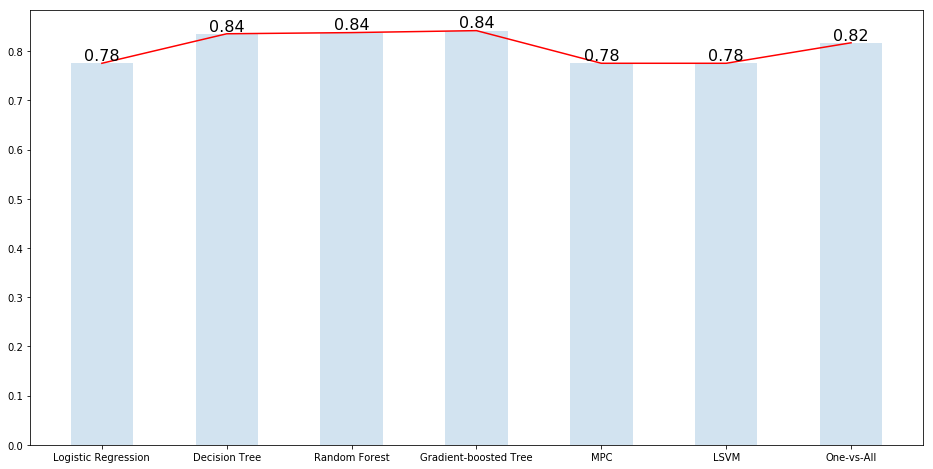

In [106]:
import matplotlib.pyplot as plt
import numpy as np

x_list = list()
y_list = list()
for x, y in enumerate(accuracy_list):
    x_list.append(x)
    y_list.append(y)
x_array = np.array(x_list)
y_array = np.array(y_list)

plt.figure(figsize=(16, 8))
plt.bar(x_array, y_array, alpha=0.2, width=0.5)
plt.plot(x_array, y_array, color='red')
plt.xticks(np.arange(7), ('Logistic Regression', 
                          'Decision Tree', 
                          'Random Forest', 
                          'Gradient-boosted Tree', 
                          'MPC', 
                          'LSVM', 
                          'One-vs-All'))

for xy in zip(x_array, y_array):
    plt.annotate('%.2f' % xy[1], 
                 xy=xy, 
                 xycoords='data', 
                 size=16, 
                 verticalalignment='bottom', 
                 horizontalalignment='center'
                )
    
plt.show()

## Step 09: Calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm. Explain how the accuracy of the predication can be improved?

In [31]:
from sklearn.metrics import confusion_matrix

y_true = predictions.select("label")
y_true = y_true.toPandas()
y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)

In [114]:
import itertools

def plot_confusion_matrix(confusion_matrix, normalize=False, cmap=plt.cm.Blues):
    
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        font_format = '.2f' 
        print("Normalized confusion matrix")
    else:
        font_format = 'd'
        print('Non-normalization Confusion matrix')

    print(confusion_matrix)
    
#     plt.figure(figsize=(16, 8))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    
    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], font_format),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black",
                 size = 24,
                )
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

### Non-normalization Confusion matrix

Non-normalization Confusion matrix
[[30737  2304]
 [ 5486  4080]]


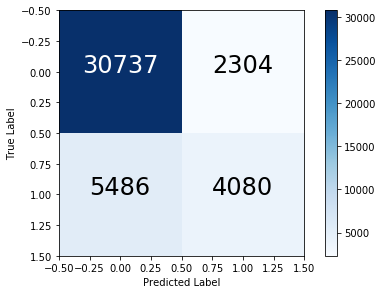

In [115]:
plot_confusion_matrix(cnf_matrix)

### Normalization Confusion matrix

Normalized confusion matrix
[[0.93026845 0.06973155]
 [0.57348944 0.42651056]]


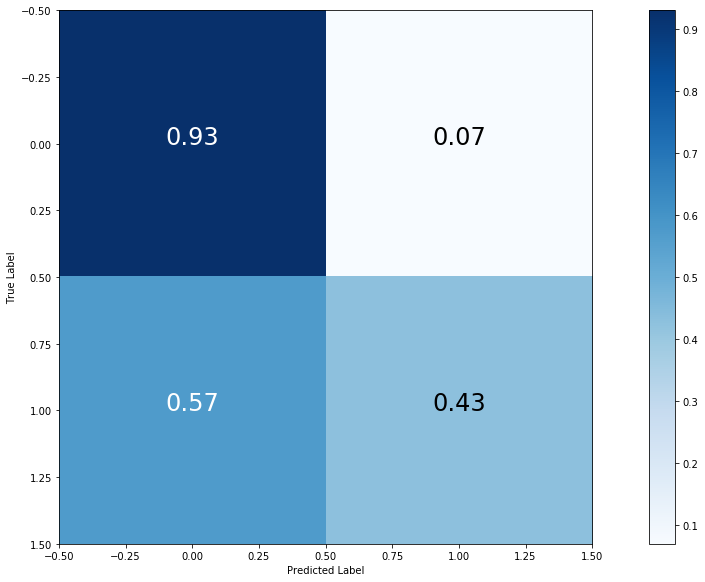

In [109]:
plot_confusion_matrix(cnf_matrix, normalize=True)